Cell 1: Imports & Configuration
python


In [1]:
# pip install --upgrade scikit-learn
# pip install xgboost lightgbm

Imports

In [2]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB

# For XGBoost / LightGBM (install if needed: pip install xgboost lightgbm)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Unsupervised example
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from joblib import Memory
from sklearn.inspection import permutation_importance


# 0) Configuration
data_dir = "D:\\Downloads\\archive (9)"
csv_files = sorted(glob.glob(os.path.join(data_dir, "dataset-of-*.csv")))
if len(csv_files) == 0:
    raise ValueError(f"No files found in {data_dir}.")

# Create a cache directory for joblib
cache_dir = "./joblib_cache"
memory = Memory(location=cache_dir, verbose=0)

print("CSV files:", [os.path.basename(fp) for fp in csv_files])


CSV files: ['dataset-of-00s.csv', 'dataset-of-10s.csv', 'dataset-of-60s.csv', 'dataset-of-70s.csv', 'dataset-of-80s.csv', 'dataset-of-90s.csv']


Cell 2: Feature & Target Columns
python

In [3]:

# 1) Load the hyperparameter‐tuning dictionaries (results, cv_results)
with open(os.path.join(output_dir, "per_decade_and_overall_results.pkl"), "rb") as f:
    saved = pickle.load(f)
    results = saved["results"]
    cv_results = saved["cv_results"]

# 2) Load best_params_per_decade and best_params_overall
with open(os.path.join(output_dir, "best_params_per_decade.pkl"), "rb") as f:
    best_params_per_decade = pickle.load(f)

with open(os.path.join(output_dir, "best_params_overall.pkl"), "rb") as f:
    best_params_overall = pickle.load(f)

# 3) Re‐construct the “best_params” DataFrames if needed
decade_labels = list(results.keys())

best_params_80_20 = pd.DataFrame({
    decade: {m: results[decade]['80/20'][m]['best_params'] for m in model_grids}
    for decade in decade_labels
}).T

best_params_70_30 = pd.DataFrame({
    decade: {m: results[decade]['70/30'][m]['best_params'] for m in model_grids}
    for decade in decade_labels
}).T

best_params_cv5 = pd.DataFrame({
    decade: {m: cv_results[decade]['CV5'][m]['best_params'] for m in model_grids}
    for decade in decade_labels
}).T

best_params_cv10 = pd.DataFrame({
    decade: {m: cv_results[decade]['CV10'][m]['best_params'] for m in model_grids}
    for decade in decade_labels
}).T

# 4) Reload the feature‐importance DataFrame
importance_df_all = pd.read_csv(
    os.path.join(output_dir, "feature_importances_all_models.csv"),
    index_col=0
)

# 5) Load KMeans cluster centers and labels/params
cluster_centers_df = pd.read_csv(
    os.path.join(output_dir, "kmeans_cluster_centers.csv"),
    index_col=0
)

with open(os.path.join(output_dir, "kmeans_labels_and_params.pkl"), "rb") as f:
    kmeans_data = pickle.load(f)
    cluster_labels = kmeans_data["cluster_labels"]
    cluster_sizes = kmeans_data["cluster_sizes"]
    best_kmeans_params = kmeans_data["best_kmeans_params"]

print("Reload complete. You now have:")
print(" • results                 (per‐decade & overall tuning dict)")
print(" • cv_results")
print(" • best_params_per_decade")
print(" • best_params_overall")
print(" • best_params_80_20, best_params_70_30, best_params_cv5, best_params_cv10")
print(" • importance_df_all")
print(" • cluster_centers_df")
print(" • cluster_labels, cluster_sizes, best_kmeans_params")

In [4]:
# 1) Feature & target
features = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
    'duration_ms', 'time_signature', 'chorus_hit', 'sections'
]
target_col = 'target'

# 2) Read each decade into a dict
decade_dfs = {}
for fp in csv_files:
    name = os.path.splitext(os.path.basename(fp))[0]
    df = pd.read_csv(fp)
    decade_dfs[name] = df

print("Loaded DataFrames:", list(decade_dfs.keys()))


Loaded DataFrames: ['dataset-of-00s', 'dataset-of-10s', 'dataset-of-60s', 'dataset-of-70s', 'dataset-of-80s', 'dataset-of-90s']


Build Overall DataFrame

In [5]:
# 3) Build overall combined DataFrame
all_dfs = list(decade_dfs.values())
df_all = pd.concat(all_dfs, ignore_index=True)
df_all = df_all[features + [target_col]].dropna()
X_all = df_all[features].values
y_all = df_all[target_col].values

print("Overall dataset shape:", df_all.shape)


Overall dataset shape: (41106, 16)


Cell 3: Define Models & Parameter Grids

In [6]:
model_grids = {
    "RandomForest": (
        RandomForestClassifier(random_state=42),
        {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    ),
    "ExtraTrees": (
        ExtraTreesClassifier(random_state=42),
        {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    ),
    "GradientBoosting": (
        GradientBoostingClassifier(random_state=42),
        {
            'n_estimators': [100, 200],
            'learning_rate': [0.1, 0.05],
            'max_depth': [3, 5]
        }
    ),
    "HistGradientBoosting": (
        HistGradientBoostingClassifier(random_state=42),
        {
            'learning_rate': [0.1, 0.05],
            'max_iter': [100, 200],
            'max_depth': [None, 10]
        }
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=42),
        {
            'n_estimators': [50, 100],
            'learning_rate': [1.0, 0.5]
        }
    ),
    "LinearSVC": (
        LinearSVC(max_iter=5000, random_state=42),
        {
            'C': [0.1, 1, 10]
        }
    ),
#     "SVC": (
#         SVC(kernel='rbf', random_state=42),
#         {
#             'C': [0.1, 1, 10],
#             'gamma': ['scale', 'auto']
#         }
#     ),
#     "NuSVC": (
#         NuSVC(kernel='rbf', random_state=42),
#         {
#             'nu': [0.25, 0.5, 0.75],
#             'gamma': ['scale', 'auto']
#         }
#     ),
    "SGD": (
        SGDClassifier(max_iter=1000, tol=1e-3, random_state=42),
        {
            'alpha': [1e-4, 1e-3, 1e-2],
            'penalty': ['l2', 'l1']
        }
    ),
#     "KNeighbors": (
#         KNeighborsClassifier(),
#         {
#             'n_neighbors': [3, 5, 7],
#             'weights': ['uniform', 'distance']
#         }
#     ),
#     "RadiusNeighbors": (
#         RadiusNeighborsClassifier(),
#         {
#             'radius': [1.0, 2.0, 5.0],
#             'weights': ['uniform', 'distance']
#         }
#     ),
#     "GaussianProcess": (
#         GaussianProcessClassifier(random_state=42),
#         {
#             'max_iter_predict': [100, 200]
#         }
#     ),
    "GaussianNB": (
        GaussianNB(),
        {
            # no hyperparameters for basic GaussianNB, so empty dict
        }
    ),
    "DecisionTree": (
        DecisionTreeClassifier(random_state=42),
        {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    )
#     "XGBoost": (
#         XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
#         {
#             'n_estimators': [100, 200],
#             'learning_rate': [0.1, 0.05],
#             'max_depth': [3, 5]
#         }
#     ),
#     "LightGBM": (
#         LGBMClassifier(random_state=42),
#         {
#             'n_estimators': [100, 200],
#             'learning_rate': [0.1, 0.05],
#             'num_leaves': [31, 63]
#         }
#     )
}

print("Extended model_grids with additional models (SVC, NuSVC, KNN, GPC, GaussianNB, XGBoost, LightGBM).")




Extended model_grids with additional models (SVC, NuSVC, KNN, GPC, GaussianNB, XGBoost, LightGBM).


Cell 4: Storage & Helper Functions

In [7]:
# 5) Storage for results
results = {}
cv_results = {}

# 6) Helper functions (no caching parameter—sklearn ≥1.7 removed memory)
from sklearn.exceptions import ConvergenceWarning
import warnings

def tune_and_evaluate_split(X_train, y_train, X_test, y_test, model, param_grid, cv_splits=5):
    """
    Run GridSearchCV on (X_train, y_train) with StratifiedKFold(cv_splits),
    optimize for F1, then try predicting on (X_test, y_test). If predict fails
    (e.g. RadiusNeighborsClassifier finds no neighbors), return test_acc=0, test_f1=0.
    """
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=skf,
        scoring="f1",
        n_jobs=-1,
        verbose=0
    )
    # Suppress any non‐finite–score warnings during grid‐search
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        warnings.filterwarnings("ignore", message="One or more of the test scores are non‐finite")
        gs.fit(X_train, y_train)

    best_clf = gs.best_estimator_
    best_params = gs.best_params_

    # Now attempt to predict; if it fails, assign zeros
    try:
        y_pred = best_clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
    except ValueError:
        # E.g. RadiusNeighborsClassifier had no neighbors -> cannot predict
        acc = 0.0
        f1 = 0.0

    return best_params, acc, f1

def tune_full_cv(X, y, model, param_grid, cv_splits=5):
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=skf,
        scoring="f1",
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X, y)
    return gs.best_params_, gs.best_score_

print("Model grids and helper functions ready.")

Model grids and helper functions ready.


Cell 5: Per‐Decade Hyperparameter Tuning

In [8]:
# ----------------------------------------
# 7) PER‐DECADE HYPERPARAMETER TUNING
# ----------------------------------------
for decade_name, df in decade_dfs.items():
    # Keep only features + target
    df = df[features + [target_col]].dropna()
    X = df[features].values
    y = df[target_col].values
    
    results[decade_name] = {}
    cv_results[decade_name] = {}
    
    # 7.1) Splits: 80/20 and 70/30
    for split_label, test_size in [('80/20', 0.20), ('70/30', 0.30)]:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=42
        )
        results[decade_name][split_label] = {}
        
        for model_name, (base_model, param_grid) in model_grids.items():
#             if model_name in ("XGBoost", "LightGBM"):
#                 continue
            best_params, test_acc, test_f1 = tune_and_evaluate_split(
                X_train, y_train, X_test, y_test,
                base_model, param_grid,
                cv_splits=5
            )
            results[decade_name][split_label][model_name] = {
                'best_params': best_params,
                'test_accuracy': test_acc,
                'test_f1': test_f1
            }
    
    # 7.2) Full‐data CV: 5‐fold & 10‐fold
    for cv_label, k in [('CV5', 5), ('CV10', 10)]:
        cv_results[decade_name][cv_label] = {}
        for model_name, (base_model, param_grid) in model_grids.items():
#             if model_name in ("XGBoost", "LightGBM"):
#                 continue
            best_params_full, mean_cv_f1 = tune_full_cv(
                X, y, base_model, param_grid, cv_splits=k
            )
            cv_results[decade_name][cv_label][model_name] = {
                'best_params': best_params_full,
                'mean_cv_f1': mean_cv_f1
            }

print("Per‐decade tuning finished.")


Per‐decade tuning finished.


1h20min

Cell 6: Overall (All Decades Combined) Tuning

In [9]:
# ----------------------------------------
# 8) OVERALL HYPERPARAMETER TUNING (ALL DECADES COMBINED) WITH TIMING
# ----------------------------------------
import time
from datetime import datetime

results['Overall'] = {}
cv_results['Overall'] = {}

# Combine all decades (we already have df_all, X_all, y_all from Cell 3)
for split_label, test_size in [('80/20', 0.20), ('70/30', 0.30)]:
    X_train, X_test, y_train, y_test = train_test_split(
        X_all, y_all, test_size=test_size, stratify=y_all, random_state=42
    )
    results['Overall'][split_label] = {}
    for model_name, (base_model, param_grid) in model_grids.items():
        print(f"{datetime.now()} | Overall {split_label} | START {model_name}")
        t0 = time.time()
        best_params, test_acc, test_f1 = tune_and_evaluate_split(
            X_train, y_train, X_test, y_test,
            base_model, param_grid,
            cv_splits=5
        )
        dt = time.time() - t0
        print(f"{datetime.now()} | Overall {split_label} | DONE  {model_name} in {dt:.1f}s | acc={test_acc:.3f}, f1={test_f1:.3f}")
        results['Overall'][split_label][model_name] = {
            'best_params': best_params,
            'test_accuracy': test_acc,
            'test_f1': test_f1
        }

# Cross‐validation on all data
for cv_label, k in [('CV5', 5), ('CV10', 10)]:
    cv_results['Overall'][cv_label] = {}
    for model_name, (base_model, param_grid) in model_grids.items():
        print(f"{datetime.now()} | Overall {cv_label} | START {model_name}")
        t0 = time.time()
        best_params_full, mean_cv_f1 = tune_full_cv(
            X_all, y_all, base_model, param_grid, cv_splits=k
        )
        dt = time.time() - t0
        print(f"{datetime.now()} | Overall {cv_label} | DONE  {model_name} in {dt:.1f}s | mean_cv_f1={mean_cv_f1:.3f}")
        cv_results['Overall'][cv_label][model_name] = {
            'best_params': best_params_full,
            'mean_cv_f1': mean_cv_f1
        }

print(f"{datetime.now()} | Overall tuning finished.")


2025-06-08 20:25:28.854637 | Overall 80/20 | START RandomForest
2025-06-08 20:27:26.111305 | Overall 80/20 | DONE  RandomForest in 117.3s | acc=0.790, f1=0.801
2025-06-08 20:27:26.111305 | Overall 80/20 | START ExtraTrees
2025-06-08 20:28:01.019564 | Overall 80/20 | DONE  ExtraTrees in 34.9s | acc=0.790, f1=0.803
2025-06-08 20:28:01.019564 | Overall 80/20 | START GradientBoosting
2025-06-08 20:31:04.714004 | Overall 80/20 | DONE  GradientBoosting in 183.7s | acc=0.787, f1=0.800
2025-06-08 20:31:04.714004 | Overall 80/20 | START HistGradientBoosting
2025-06-08 20:31:11.139241 | Overall 80/20 | DONE  HistGradientBoosting in 6.4s | acc=0.788, f1=0.800
2025-06-08 20:31:11.139241 | Overall 80/20 | START AdaBoost
2025-06-08 20:31:27.556415 | Overall 80/20 | DONE  AdaBoost in 16.4s | acc=0.748, f1=0.767
2025-06-08 20:31:27.556415 | Overall 80/20 | START LinearSVC
2025-06-08 20:31:28.564710 | Overall 80/20 | DONE  LinearSVC in 1.0s | acc=0.592, f1=0.602
2025-06-08 20:31:28.564710 | Overall 80/

Cell 7: Summarize & Display All Results

In [10]:
# ----------------------------------------
# 9) SUMMARIZE & DISPLAY RESULTS
# ----------------------------------------
def build_metric_df(results_dict, metric_key, index_labels, split_label):
    rows = []
    for label in index_labels:
        row = {m: results_dict[label][split_label][m][metric_key] for m in model_grids}
        rows.append(row)
    df = pd.DataFrame(rows, index=index_labels, columns=model_grids.keys())
    return df

def build_cv_df(cv_dict, metric_key, index_labels, cv_label):
    rows = []
    for label in index_labels:
        row = {m: cv_dict[label][cv_label][m][metric_key] for m in model_grids}
        rows.append(row)
    df = pd.DataFrame(rows, index=index_labels, columns=model_grids.keys())
    return df

decade_labels = list(results.keys())

# Test Accuracy & F1 for 80/20 and 70/30
acc_80_20 = build_metric_df(results, 'test_accuracy', decade_labels, '80/20')
f1_80_20  = build_metric_df(results, 'test_f1', decade_labels, '80/20')
acc_70_30 = build_metric_df(results, 'test_accuracy', decade_labels, '70/30')
f1_70_30  = build_metric_df(results, 'test_f1', decade_labels, '70/30')

print("=== Test Accuracy (80/20 Split) ===")
display(acc_80_20)
print("\n=== Test F1 (80/20 Split) ===")
display(f1_80_20)
print("\n=== Test Accuracy (70/30 Split) ===")
display(acc_70_30)
print("\n=== Test F1 (70/30 Split) ===")
display(f1_70_30)

# Best model by split
print("\n=== Best Model per Decade (80/20 by F1) ===")
display(f1_80_20.idxmax(axis=1).to_frame(name="Best Model"))
print("\n=== Best Model per Decade (70/30 by F1) ===")
display(f1_70_30.idxmax(axis=1).to_frame(name="Best Model"))

# Cross‐Validation results
cv5_df  = build_cv_df(cv_results, 'mean_cv_f1', decade_labels, 'CV5')
cv10_df = build_cv_df(cv_results, 'mean_cv_f1', decade_labels, 'CV10')

print("\n=== Mean CV F1 (5-Fold) ===")
display(cv5_df)
print("\n=== Mean CV F1 (10-Fold) ===")
display(cv10_df)

print("\n=== Best Model per Decade (5-Fold CV) ===")
display(cv5_df.idxmax(axis=1).to_frame(name="Best Model"))
print("\n=== Best Model per Decade (10-Fold CV) ===")
display(cv10_df.idxmax(axis=1).to_frame(name="Best Model"))

# Best hyperparameters tables
print("\n=== Best Hyperparameters (80/20) ===")
best_params_80_20 = pd.DataFrame({
    decade: {m: results[decade]['80/20'][m]['best_params'] for m in model_grids}
    for decade in decade_labels
}).T
display(best_params_80_20)

print("\n=== Best Hyperparameters (70/30) ===")
best_params_70_30 = pd.DataFrame({
    decade: {m: results[decade]['70/30'][m]['best_params'] for m in model_grids}
    for decade in decade_labels
}).T
display(best_params_70_30)

print("\n=== Best Hyperparameters (5-Fold CV) ===")
best_params_cv5 = pd.DataFrame({
    decade: {m: cv_results[decade]['CV5'][m]['best_params'] for m in model_grids}
    for decade in decade_labels
}).T
display(best_params_cv5)

print("\n=== Best Hyperparameters (10-Fold CV) ===")
best_params_cv10 = pd.DataFrame({
    decade: {m: cv_results[decade]['CV10'][m]['best_params'] for m in model_grids}
    for decade in decade_labels
}).T
display(best_params_cv10)

print("Hyperparameter tuning summary done.")


=== Test Accuracy (80/20 Split) ===


,RandomForest,ExtraTrees,GradientBoosting,HistGradientBoosting,AdaBoost,LinearSVC,SGD,GaussianNB,DecisionTree
dataset-of-00s,0.862979,0.853617,0.870638,0.864681,0.851915,0.626383,0.506383,0.681702,0.820426
dataset-of-10s,0.842187,0.835156,0.842187,0.846094,0.822656,0.633594,0.500000,0.659375,0.803906
dataset-of-60s,0.771544,0.769809,0.766917,0.775014,0.756507,0.643725,0.500289,0.648352,0.716599
dataset-of-70s,0.763835,0.768983,0.777992,0.779279,0.727799,0.696268,0.500000,0.600386,0.727156
dataset-of-80s,0.806078,0.801013,0.807525,0.813314,0.772069,0.680897,0.552822,0.640376,0.742402
dataset-of-90s,0.839674,0.834239,0.838768,0.842391,0.815217,0.684783,0.500000,0.706522,0.800725
Overall,0.790440,0.790319,0.787035,0.787886,0.747628,0.592435,0.500000,0.631355,0.756993



=== Test F1 (80/20 Split) ===


,RandomForest,ExtraTrees,GradientBoosting,HistGradientBoosting,AdaBoost,LinearSVC,SGD,GaussianNB,DecisionTree
dataset-of-00s,0.868357,0.863492,0.876623,0.869565,0.860353,0.639277,0.669327,0.751660,0.828873
dataset-of-10s,0.848576,0.847212,0.849478,0.853313,0.834186,0.659405,0.666667,0.733170,0.814212
dataset-of-60s,0.789333,0.787166,0.784377,0.791644,0.777602,0.662281,0.000000,0.732159,0.737124
dataset-of-70s,0.783225,0.788201,0.793041,0.792247,0.751323,0.725262,0.666667,0.700434,0.752047
dataset-of-80s,0.813630,0.816299,0.816804,0.821330,0.789015,0.717850,0.667742,0.720000,0.757493
dataset-of-90s,0.848069,0.841558,0.846816,0.848958,0.826825,0.700000,0.000000,0.757485,0.809028
Overall,0.801246,0.803421,0.799725,0.800183,0.766723,0.602255,0.000000,0.715212,0.774746



=== Test Accuracy (70/30 Split) ===


,RandomForest,ExtraTrees,GradientBoosting,HistGradientBoosting,AdaBoost,LinearSVC,SGD,GaussianNB,DecisionTree
dataset-of-00s,0.870034,0.862656,0.870602,0.872304,0.845062,0.632236,0.500000,0.679342,0.809308
dataset-of-10s,0.842708,0.840104,0.838542,0.839583,0.815625,0.616146,0.500000,0.665104,0.799479
dataset-of-60s,0.766680,0.765137,0.768608,0.769765,0.752410,0.644042,0.499807,0.648284,0.719630
dataset-of-70s,0.772103,0.782403,0.781545,0.778112,0.731330,0.614592,0.500000,0.598712,0.708155
dataset-of-80s,0.793054,0.793054,0.802219,0.806561,0.773758,0.709117,0.499759,0.633382,0.751085
dataset-of-90s,0.851449,0.842995,0.847826,0.846618,0.826087,0.677536,0.500000,0.711353,0.786232
Overall,0.786815,0.781301,0.785031,0.785274,0.747811,0.589848,0.496675,0.631690,0.755595



=== Test F1 (70/30 Split) ===


,RandomForest,ExtraTrees,GradientBoosting,HistGradientBoosting,AdaBoost,LinearSVC,SGD,GaussianNB,DecisionTree
dataset-of-00s,0.874383,0.870172,0.875137,0.877250,0.853462,0.653105,0.666667,0.749889,0.820128
dataset-of-10s,0.847936,0.850317,0.845618,0.843972,0.825787,0.633151,0.000000,0.735282,0.807211
dataset-of-60s,0.789419,0.787583,0.787986,0.787620,0.776928,0.659032,0.666495,0.731922,0.744104
dataset-of-70s,0.791356,0.799842,0.795336,0.788548,0.751784,0.624268,0.000000,0.700608,0.728868
dataset-of-80s,0.805089,0.808738,0.810185,0.815462,0.783771,0.741091,0.666452,0.713424,0.770053
dataset-of-90s,0.859429,0.851767,0.855172,0.854023,0.836177,0.691329,0.000000,0.763834,0.792740
Overall,0.799512,0.799762,0.798541,0.797739,0.768911,0.596458,0.000000,0.715520,0.774300



=== Best Model per Decade (80/20 by F1) ===


,Best Model
dataset-of-00s,GradientBoosting
dataset-of-10s,HistGradientBoosting
dataset-of-60s,HistGradientBoosting
dataset-of-70s,GradientBoosting
dataset-of-80s,HistGradientBoosting
dataset-of-90s,HistGradientBoosting
Overall,ExtraTrees



=== Best Model per Decade (70/30 by F1) ===


,Best Model
dataset-of-00s,HistGradientBoosting
dataset-of-10s,ExtraTrees
dataset-of-60s,RandomForest
dataset-of-70s,ExtraTrees
dataset-of-80s,HistGradientBoosting
dataset-of-90s,RandomForest
Overall,ExtraTrees



=== Mean CV F1 (5-Fold) ===


,RandomForest,ExtraTrees,GradientBoosting,HistGradientBoosting,AdaBoost,LinearSVC,SGD,GaussianNB,DecisionTree
dataset-of-00s,0.859852,0.863778,0.861914,0.861622,0.847446,0.670051,0.400000,0.748237,0.820545
dataset-of-10s,0.853897,0.855782,0.850274,0.852251,0.827535,0.668329,0.533333,0.739187,0.816815
dataset-of-60s,0.792391,0.788104,0.792883,0.795198,0.767142,0.659085,0.480340,0.732636,0.754046
dataset-of-70s,0.791440,0.787884,0.788161,0.790014,0.753118,0.604533,0.533276,0.696248,0.751590
dataset-of-80s,0.813974,0.816194,0.811893,0.814759,0.789416,0.744889,0.666667,0.716441,0.767949
dataset-of-90s,0.855388,0.856587,0.855843,0.855053,0.838872,0.665980,0.400977,0.761796,0.813609
Overall,0.800772,0.800061,0.796362,0.798035,0.767889,0.604425,0.406232,0.712604,0.773114



=== Mean CV F1 (10-Fold) ===


,RandomForest,ExtraTrees,GradientBoosting,HistGradientBoosting,AdaBoost,LinearSVC,SGD,GaussianNB,DecisionTree
dataset-of-00s,0.861766,0.865224,0.861615,0.861437,0.845837,0.651343,0.400075,0.748757,0.820487
dataset-of-10s,0.853550,0.856344,0.851878,0.854921,0.829186,0.649161,0.281538,0.739659,0.809109
dataset-of-60s,0.790876,0.788421,0.790738,0.793472,0.766253,0.658238,0.466667,0.732069,0.752989
dataset-of-70s,0.792655,0.788669,0.789903,0.789338,0.753286,0.599256,0.399943,0.695853,0.751212
dataset-of-80s,0.814303,0.814455,0.813069,0.819776,0.786575,0.738123,0.308677,0.716804,0.767991
dataset-of-90s,0.855925,0.858112,0.857115,0.858817,0.840448,0.669686,0.334397,0.760568,0.818482
Overall,0.801551,0.801580,0.798586,0.799406,0.767361,0.611906,0.451940,0.712643,0.774701



=== Best Model per Decade (5-Fold CV) ===


,Best Model
dataset-of-00s,ExtraTrees
dataset-of-10s,ExtraTrees
dataset-of-60s,HistGradientBoosting
dataset-of-70s,RandomForest
dataset-of-80s,ExtraTrees
dataset-of-90s,ExtraTrees
Overall,RandomForest



=== Best Model per Decade (10-Fold CV) ===


,Best Model
dataset-of-00s,ExtraTrees
dataset-of-10s,ExtraTrees
dataset-of-60s,HistGradientBoosting
dataset-of-70s,RandomForest
dataset-of-80s,HistGradientBoosting
dataset-of-90s,HistGradientBoosting
Overall,ExtraTrees



=== Best Hyperparameters (80/20) ===


,RandomForest,ExtraTrees,GradientBoosting,HistGradientBoosting,AdaBoost,LinearSVC,SGD,GaussianNB,DecisionTree
dataset-of-00s,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...","{'max_depth': 20, 'min_samples_split': 5, 'n_e...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'learning_rate': 0.05, 'max_depth': None, 'ma...","{'learning_rate': 0.5, 'n_estimators': 100}",{'C': 0.1},"{'alpha': 0.0001, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 5}"
dataset-of-10s,"{'max_depth': None, 'min_samples_split': 5, 'n...","{'max_depth': None, 'min_samples_split': 5, 'n...","{'learning_rate': 0.05, 'max_depth': 5, 'n_est...","{'learning_rate': 0.05, 'max_depth': 10, 'max_...","{'learning_rate': 1.0, 'n_estimators': 100}",{'C': 0.1},"{'alpha': 0.01, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 5}"
dataset-of-60s,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...","{'max_depth': None, 'min_samples_split': 5, 'n...","{'learning_rate': 0.05, 'max_depth': 5, 'n_est...","{'learning_rate': 0.05, 'max_depth': 10, 'max_...","{'learning_rate': 1.0, 'n_estimators': 100}",{'C': 0.1},"{'alpha': 0.0001, 'penalty': 'l2'}",{},"{'max_depth': 10, 'min_samples_split': 2}"
dataset-of-70s,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...","{'max_depth': 20, 'min_samples_split': 2, 'n_e...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'learning_rate': 0.05, 'max_depth': 10, 'max_...","{'learning_rate': 0.5, 'n_estimators': 100}",{'C': 10},"{'alpha': 0.0001, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 5}"
dataset-of-80s,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...","{'max_depth': 20, 'min_samples_split': 2, 'n_e...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...","{'learning_rate': 0.5, 'n_estimators': 100}",{'C': 0.1},"{'alpha': 0.01, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 5}"
dataset-of-90s,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...","{'max_depth': None, 'min_samples_split': 5, 'n...","{'learning_rate': 0.05, 'max_depth': 3, 'n_est...","{'learning_rate': 0.05, 'max_depth': None, 'ma...","{'learning_rate': 0.5, 'n_estimators': 100}",{'C': 0.1},"{'alpha': 0.0001, 'penalty': 'l2'}",{},"{'max_depth': 10, 'min_samples_split': 2}"
Overall,"{'max_depth': None, 'min_samples_split': 5, 'n...","{'max_depth': None, 'min_samples_split': 5, 'n...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...","{'learning_rate': 0.5, 'n_estimators': 100}",{'C': 0.1},"{'alpha': 0.0001, 'penalty': 'l2'}",{},"{'max_depth': 10, 'min_samples_split': 2}"



=== Best Hyperparameters (70/30) ===


,RandomForest,ExtraTrees,GradientBoosting,HistGradientBoosting,AdaBoost,LinearSVC,SGD,GaussianNB,DecisionTree
dataset-of-00s,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...","{'max_depth': None, 'min_samples_split': 5, 'n...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'learning_rate': 0.05, 'max_depth': None, 'ma...","{'learning_rate': 0.5, 'n_estimators': 100}",{'C': 10},"{'alpha': 0.01, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 2}"
dataset-of-10s,"{'max_depth': None, 'min_samples_split': 2, 'n...","{'max_depth': None, 'min_samples_split': 2, 'n...","{'learning_rate': 0.05, 'max_depth': 3, 'n_est...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...","{'learning_rate': 1.0, 'n_estimators': 100}",{'C': 0.1},"{'alpha': 0.01, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 5}"
dataset-of-60s,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...","{'max_depth': 20, 'min_samples_split': 2, 'n_e...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...","{'learning_rate': 0.05, 'max_depth': 10, 'max_...","{'learning_rate': 0.5, 'n_estimators': 100}",{'C': 10},"{'alpha': 0.0001, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 2}"
dataset-of-70s,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...","{'max_depth': 20, 'min_samples_split': 2, 'n_e...","{'learning_rate': 0.05, 'max_depth': 5, 'n_est...","{'learning_rate': 0.05, 'max_depth': 10, 'max_...","{'learning_rate': 0.5, 'n_estimators': 100}",{'C': 0.1},"{'alpha': 0.0001, 'penalty': 'l2'}",{},"{'max_depth': 10, 'min_samples_split': 5}"
dataset-of-80s,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...","{'max_depth': 20, 'min_samples_split': 2, 'n_e...","{'learning_rate': 0.05, 'max_depth': 5, 'n_est...","{'learning_rate': 0.05, 'max_depth': 10, 'max_...","{'learning_rate': 1.0, 'n_estimators': 100}",{'C': 0.1},"{'alpha': 0.01, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 2}"
dataset-of-90s,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...","{'max_depth': 20, 'min_samples_split': 2, 'n_e...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'learning_rate': 0.05, 'max_depth': None, 'ma...","{'learning_rate': 0.5, 'n_estimators': 100}",{'C': 0.1},"{'alpha': 0.01, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 2}"
Overall,"{'max_depth': 20, 'min_samples_split': 5, 'n_e...","{'max_depth': 20, 'min_samples_split': 2, 'n_e...","{'learning_rate': 0.05, 'max_depth': 5, 'n_est...","{'learning_rate': 0.05, 'max_depth': 10, 'max_...","{'learning_rate': 0.5, 'n_estimators': 100}",{'C': 0.1},"{'alpha': 0.001, 'penalty': 'l2'}",{},"{'max_depth': 10, 'min_samples_split': 2}"



=== Best Hyperparameters (5-Fold CV) ===


,RandomForest,ExtraTrees,GradientBoosting,HistGradientBoosting,AdaBoost,LinearSVC,SGD,GaussianNB,DecisionTree
dataset-of-00s,"{'max_depth': None, 'min_samples_split': 5, 'n...","{'max_depth': 20, 'min_samples_split': 2, 'n_e...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...","{'learning_rate': 0.05, 'max_depth': None, 'ma...","{'learning_rate': 1.0, 'n_estimators': 100}",{'C': 0.1},"{'alpha': 0.01, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 5}"
dataset-of-10s,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...","{'max_depth': None, 'min_samples_split': 2, 'n...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...","{'learning_rate': 0.05, 'max_depth': 10, 'max_...","{'learning_rate': 1.0, 'n_estimators': 100}",{'C': 0.1},"{'alpha': 0.001, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 5}"
dataset-of-60s,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...","{'max_depth': None, 'min_samples_split': 5, 'n...","{'learning_rate': 0.05, 'max_depth': 5, 'n_est...","{'learning_rate': 0.05, 'max_depth': 10, 'max_...","{'learning_rate': 0.5, 'n_estimators': 100}",{'C': 0.1},"{'alpha': 0.0001, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 2}"
dataset-of-70s,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...","{'max_depth': None, 'min_samples_split': 2, 'n...","{'learning_rate': 0.05, 'max_depth': 5, 'n_est...","{'learning_rate': 0.05, 'max_depth': None, 'ma...","{'learning_rate': 0.5, 'n_estimators': 100}",{'C': 1},"{'alpha': 0.0001, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 5}"
dataset-of-80s,"{'max_depth': None, 'min_samples_split': 5, 'n...","{'max_depth': 20, 'min_samples_split': 2, 'n_e...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...","{'learning_rate': 1.0, 'n_estimators': 100}",{'C': 1},"{'alpha': 0.01, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 2}"
dataset-of-90s,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...","{'max_depth': 20, 'min_samples_split': 2, 'n_e...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'learning_rate': 0.05, 'max_depth': 10, 'max_...","{'learning_rate': 0.5, 'n_estimators': 100}",{'C': 0.1},"{'alpha': 0.0001, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 2}"
Overall,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...","{'max_depth': None, 'min_samples_split': 5, 'n...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...","{'learning_rate': 0.05, 'max_depth': None, 'ma...","{'learning_rate': 0.5, 'n_estimators': 100}",{'C': 0.1},"{'alpha': 0.0001, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 5}"



=== Best Hyperparameters (10-Fold CV) ===


,RandomForest,ExtraTrees,GradientBoosting,HistGradientBoosting,AdaBoost,LinearSVC,SGD,GaussianNB,DecisionTree
dataset-of-00s,"{'max_depth': None, 'min_samples_split': 2, 'n...","{'max_depth': None, 'min_samples_split': 2, 'n...","{'learning_rate': 0.05, 'max_depth': 3, 'n_est...","{'learning_rate': 0.05, 'max_depth': None, 'ma...","{'learning_rate': 1.0, 'n_estimators': 100}",{'C': 10},"{'alpha': 0.0001, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 2}"
dataset-of-10s,"{'max_depth': None, 'min_samples_split': 5, 'n...","{'max_depth': None, 'min_samples_split': 2, 'n...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...","{'learning_rate': 0.05, 'max_depth': None, 'ma...","{'learning_rate': 1.0, 'n_estimators': 100}",{'C': 0.1},"{'alpha': 0.0001, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 2}"
dataset-of-60s,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...","{'max_depth': None, 'min_samples_split': 2, 'n...","{'learning_rate': 0.05, 'max_depth': 5, 'n_est...","{'learning_rate': 0.1, 'max_depth': None, 'max...","{'learning_rate': 0.5, 'n_estimators': 100}",{'C': 10},"{'alpha': 0.001, 'penalty': 'l2'}",{},"{'max_depth': 10, 'min_samples_split': 5}"
dataset-of-70s,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...","{'max_depth': 20, 'min_samples_split': 2, 'n_e...","{'learning_rate': 0.05, 'max_depth': 5, 'n_est...","{'learning_rate': 0.05, 'max_depth': None, 'ma...","{'learning_rate': 0.5, 'n_estimators': 100}",{'C': 1},"{'alpha': 0.0001, 'penalty': 'l2'}",{},"{'max_depth': 10, 'min_samples_split': 2}"
dataset-of-80s,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...","{'max_depth': 20, 'min_samples_split': 5, 'n_e...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...","{'learning_rate': 0.1, 'max_depth': None, 'max...","{'learning_rate': 0.5, 'n_estimators': 100}",{'C': 0.1},"{'alpha': 0.0001, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 2}"
dataset-of-90s,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...","{'max_depth': 20, 'min_samples_split': 2, 'n_e...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...","{'learning_rate': 0.1, 'max_depth': None, 'max...","{'learning_rate': 0.5, 'n_estimators': 100}",{'C': 10},"{'alpha': 0.0001, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 2}"
Overall,"{'max_depth': 20, 'min_samples_split': 5, 'n_e...","{'max_depth': None, 'min_samples_split': 5, 'n...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...","{'learning_rate': 0.5, 'n_estimators': 100}",{'C': 0.1},"{'alpha': 0.001, 'penalty': 'l1'}",{},"{'max_depth': 10, 'min_samples_split': 2}"


Hyperparameter tuning summary done.


best params, model_classes

In [11]:
# ----------------------------------------
# A) AUTOMATICALLY BUILD best_params_per_decade AND best_params_overall
# ----------------------------------------

# 1) best_params_per_decade: a dict mapping each decade to a dict of {model_name: best_params}
best_params_per_decade = {
    decade: {
        model_name: results[decade]['80/20'][model_name]['best_params']
        for model_name in model_grids
    }
    for decade in decade_dfs.keys()
}

# 2) best_params_overall: use the “Overall” 80/20 split to pick each model’s best params
best_params_overall = {
    model_name: results['Overall']['80/20'][model_name]['best_params']
    for model_name in model_grids
}

# (Optional) If you’d prefer to pick best_params from CV5 or CV10 instead,
# just replace '80/20' with 'CV5' (and adjust the dict structure accordingly).

print("Best parameters per decade (80/20 split):")
for decade, params_dict in best_params_per_decade.items():
    print(f"\n{decade}:")
    for model_name, p in params_dict.items():
        print(f"  {model_name}: {p}")

print("\nBest parameters Overall (80/20 split):")
for model_name, p in best_params_overall.items():
    print(f"  {model_name}: {p}")

# ----------------------------------------
# 2) MAP EACH MODEL NAME TO ITS SKLEARN CLASS
# ----------------------------------------
model_classes = {
    'RandomForest': RandomForestClassifier,
    'ExtraTrees':   ExtraTreesClassifier,
    'GradientBoosting': GradientBoostingClassifier,
    'HistGradientBoosting': HistGradientBoostingClassifier,
    'AdaBoost':     AdaBoostClassifier,
    'LinearSVC':    LinearSVC,
#     'SVC':          SVC,
#     'NuSVC':        NuSVC,
    'SGD':          SGDClassifier,
#     'KNeighbors':   KNeighborsClassifier,
#     'RadiusNeighbors': RadiusNeighborsClassifier,
#     'GaussianProcess': GaussianProcessClassifier,
    'GaussianNB':   GaussianNB,
    'DecisionTree': DecisionTreeClassifier,
#     'XGBoost':      XGBClassifier,
#     'LightGBM':     LGBMClassifier
}

print("\nmodel_classes is defined with all supervised models.")

Best parameters per decade (80/20 split):

dataset-of-00s:
  RandomForest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
  ExtraTrees: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
  GradientBoosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
  HistGradientBoosting: {'learning_rate': 0.05, 'max_depth': None, 'max_iter': 100}
  AdaBoost: {'learning_rate': 0.5, 'n_estimators': 100}
  LinearSVC: {'C': 0.1}
  SGD: {'alpha': 0.0001, 'penalty': 'l1'}
  GaussianNB: {}
  DecisionTree: {'max_depth': 10, 'min_samples_split': 5}

dataset-of-10s:
  RandomForest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
  ExtraTrees: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
  GradientBoosting: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
  HistGradientBoosting: {'learning_rate': 0.05, 'max_depth': 10, 'max_iter': 100}
  AdaBoost: {'learning_rate': 1.0, 'n_estimators': 100}
  LinearSVC: {'C': 0.1}
  SG

Feature Importance: Fit & Extract Weights

In [12]:
# ----------------------------------------
# FEATURE IMPORTANCE (ALL MODELS): FIT, EXTRACT & PROGRESS PRINTS
# ----------------------------------------
import numpy as np
from datetime import datetime
importance_dict = {}

for model_name, ModelClass in model_classes.items():
    print(f"{datetime.now()} ▶ Starting feature importances for {model_name}")
    params = best_params_overall.get(model_name, {})
    model = ModelClass(**params)
    
    t0 = datetime.now()
    model.fit(X_all, y_all)
    print(f"{datetime.now()}    • Fitted {model_name} (took { (datetime.now()-t0).total_seconds():.1f}s )")
    
    if hasattr(model, "feature_importances_"):
        print(f"{datetime.now()}    • Using built-in feature_importances_ for {model_name}")
        raw_imp = model.feature_importances_
        
    elif hasattr(model, "coef_"):
        print(f"{datetime.now()}    • Using |coef_| for {model_name}")
        raw_imp = np.abs(model.coef_).flatten()
        
    else:
        print(f"{datetime.now()}    • Computing permutation importance for {model_name} …")
        t1 = datetime.now()
        r = permutation_importance(
            estimator=model,
            X=X_all,
            y=y_all,
            n_repeats=10,
            random_state=42,
            n_jobs=-1,
            scoring="f1"
        )
        raw_imp = r.importances_mean
        print(f"{datetime.now()}    • Permutation importance done (took { (datetime.now()-t1).total_seconds():.1f}s )")
    
    norm_imp = raw_imp / np.sum(raw_imp)
    importance_dict[model_name] = pd.Series(norm_imp, index=features)
    print(f"{datetime.now()} ✔ Completed importances for {model_name}\n")

importance_df_all = pd.DataFrame(importance_dict)
print(f"{datetime.now()} 🏁 Built feature importance DataFrame (models ✓):")
display(importance_df_all)


2025-06-08 20:55:28.657522 ▶ Starting feature importances for RandomForest
2025-06-08 20:56:15.086877    • Fitted RandomForest (took 46.4s )
2025-06-08 20:56:15.137828    • Using built-in feature_importances_ for RandomForest
2025-06-08 20:56:15.187784 ✔ Completed importances for RandomForest

2025-06-08 20:56:15.187784 ▶ Starting feature importances for ExtraTrees
2025-06-08 20:56:29.122155    • Fitted ExtraTrees (took 13.9s )
2025-06-08 20:56:29.223925    • Using built-in feature_importances_ for ExtraTrees
2025-06-08 20:56:29.317694 ✔ Completed importances for ExtraTrees

2025-06-08 20:56:29.317694 ▶ Starting feature importances for GradientBoosting
2025-06-08 20:57:59.857475    • Fitted GradientBoosting (took 90.5s )
2025-06-08 20:57:59.859463    • Using built-in feature_importances_ for GradientBoosting
2025-06-08 20:57:59.860857 ✔ Completed importances for GradientBoosting

2025-06-08 20:57:59.860857 ▶ Starting feature importances for HistGradientBoosting
2025-06-08 20:58:00.5676

,RandomForest,ExtraTrees,GradientBoosting,HistGradientBoosting,AdaBoost,LinearSVC,SGD,GaussianNB,DecisionTree
danceability,0.104236,0.106282,0.112519,0.101349,0.089539,0.058673,0.010511,0.000722,0.113239
energy,0.079732,0.082043,0.054573,0.051968,0.014415,0.018790,0.008453,0.000367,0.061223
key,0.026258,0.038319,0.004968,0.007508,0.000000,0.081332,0.028153,0.001030,0.004663
loudness,0.072641,0.063110,0.032258,0.065266,0.097630,0.412204,0.152675,0.430489,0.019882
mode,0.009755,0.015676,0.012852,0.023535,0.000000,0.043247,0.007948,0.000473,0.011032
speechiness,0.073599,0.055092,0.073699,0.078671,0.048430,0.003152,0.000134,0.000136,0.062503
acousticness,0.114485,0.114673,0.136466,0.206214,0.202090,0.039968,0.009301,0.000615,0.140567
instrumentalness,0.179942,0.206825,0.401632,0.266368,0.277515,0.092954,0.015508,0.003393,0.443163
liveness,0.048941,0.041854,0.012031,0.008906,0.000000,0.007363,0.000279,0.000076,0.008633
valence,0.072407,0.069606,0.045279,0.051713,0.048981,0.056529,0.011192,0.000631,0.035414


Display & Plot Feature Importances

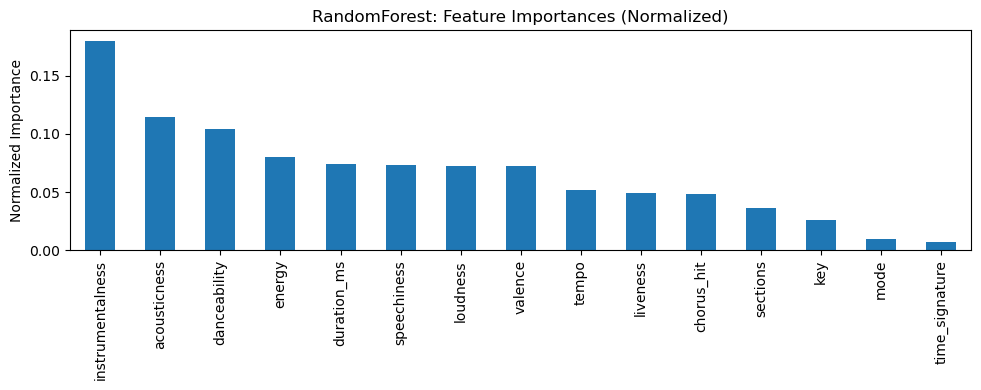

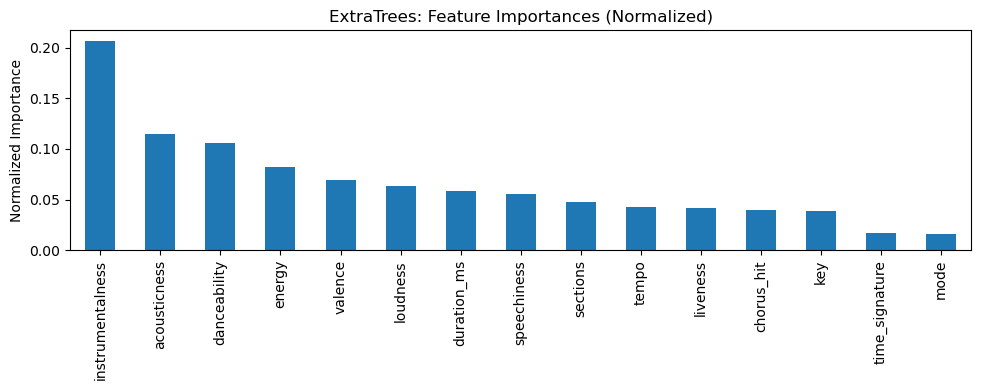

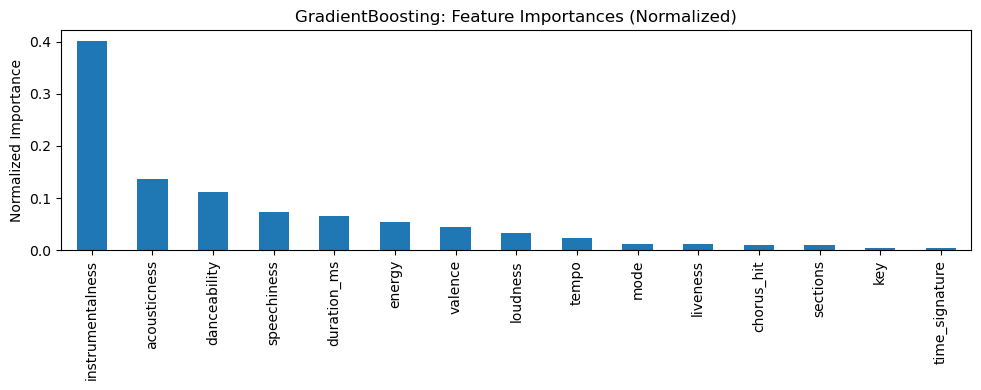

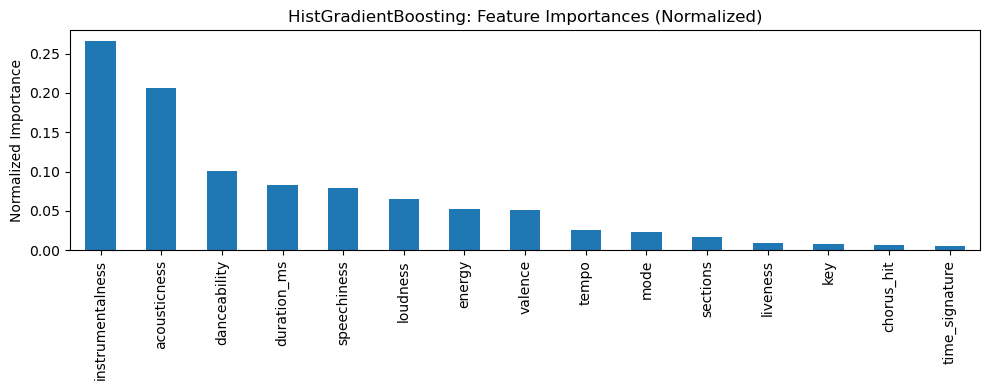

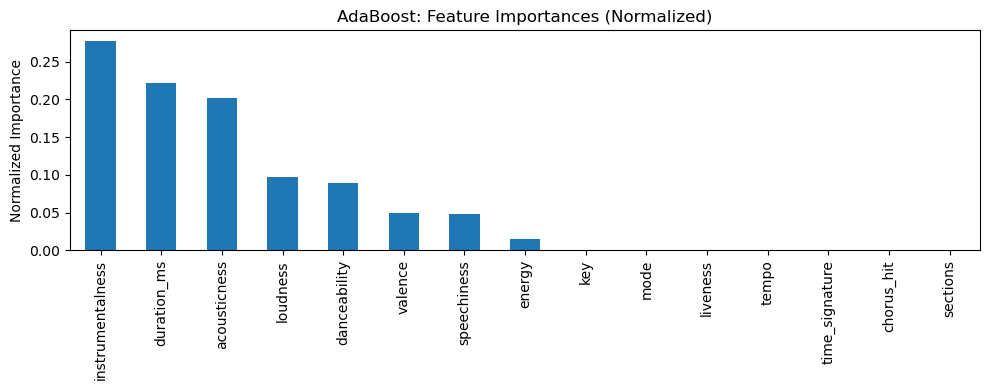

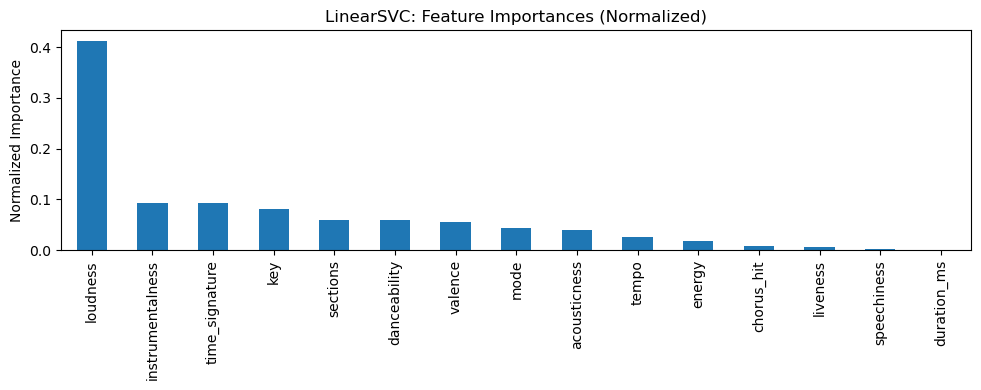

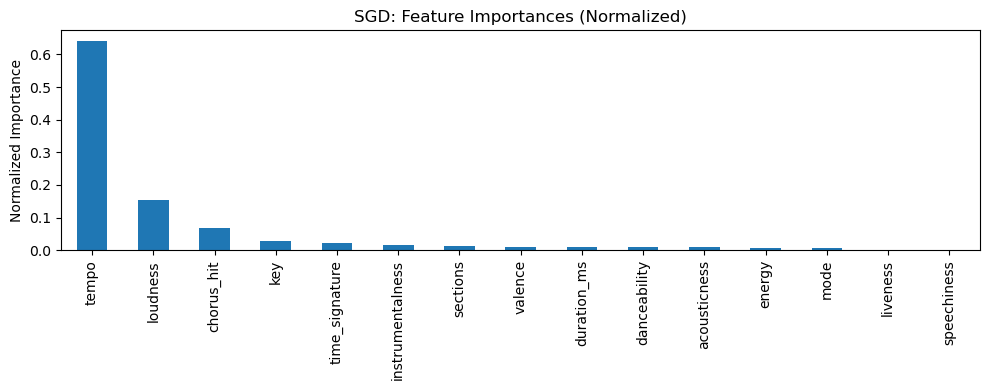

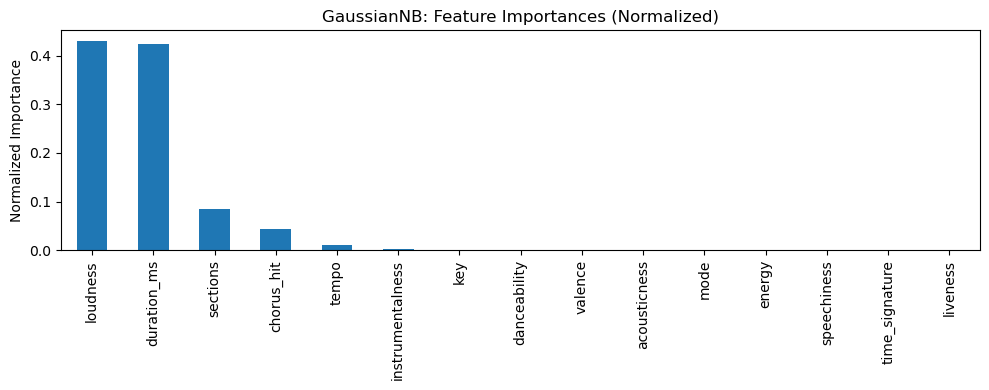

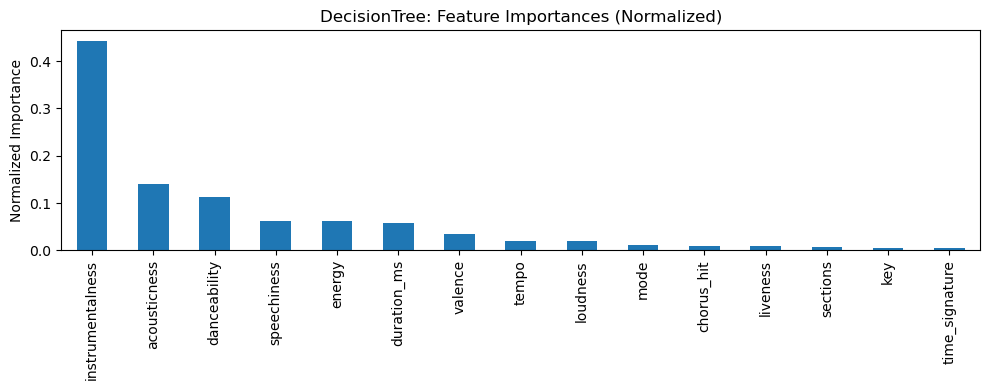

Top 5 features per model:

RandomForest: ['instrumentalness', 'acousticness', 'danceability', 'energy', 'duration_ms']
ExtraTrees: ['instrumentalness', 'acousticness', 'danceability', 'energy', 'valence']
GradientBoosting: ['instrumentalness', 'acousticness', 'danceability', 'speechiness', 'duration_ms']
HistGradientBoosting: ['instrumentalness', 'acousticness', 'danceability', 'duration_ms', 'speechiness']
AdaBoost: ['instrumentalness', 'duration_ms', 'acousticness', 'loudness', 'danceability']
LinearSVC: ['loudness', 'instrumentalness', 'time_signature', 'key', 'sections']
SGD: ['tempo', 'loudness', 'chorus_hit', 'key', 'time_signature']
GaussianNB: ['loudness', 'duration_ms', 'sections', 'chorus_hit', 'tempo']
DecisionTree: ['instrumentalness', 'acousticness', 'danceability', 'speechiness', 'energy']


In [16]:
# ----------------------------------------
# 11) PLOT FEATURE IMPORTANCES FOR EACH MODEL
# ----------------------------------------

from matplotlib import pyplot as plt

for model_name in importance_df_all.columns:
    plt.figure(figsize=(10, 4))
    importance_df_all[model_name].sort_values(ascending=False).plot(kind='bar')
    plt.title(f"{model_name}: Feature Importances (Normalized)")
    plt.ylabel("Normalized Importance")
    plt.tight_layout()
    plt.show()

# ----------------------------------------
# 12) PRINT TOP‐5 FEATURES FOR EACH MODEL
# ----------------------------------------
top_n = 5
print(f"Top {top_n} features per model:\n")
for model_name in importance_df_all.columns:
    top_feats = list(importance_df_all[model_name].nlargest(top_n).index)
    print(f"{model_name}: {top_feats}")


Unsupervised PCA + KMeans

Best KMeans init for 2 clusters (by silhouette): random
Best silhouette score: 0.19694624025012028

Cluster centers (original feature units) for 2 clusters, init='random':


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections
Cluster 0,0.587693,0.697941,5.273028,-8.064360,0.688811,0.079404,0.215026,0.087968,0.208886,0.621915,123.023683,230654.800157,3.969341,39.941860,10.223852
Cluster 1,0.420247,0.284906,5.065688,-15.589816,0.704659,0.056925,0.735423,0.319777,0.183241,0.344662,110.166732,245386.224561,3.705423,40.514619,11.102351



Top 5 features per cluster (absolute center value) for 2 clusters:

Cluster 0: ['duration_ms', 'tempo', 'chorus_hit', 'sections', 'loudness']
Cluster 1: ['duration_ms', 'tempo', 'chorus_hit', 'loudness', 'sections']


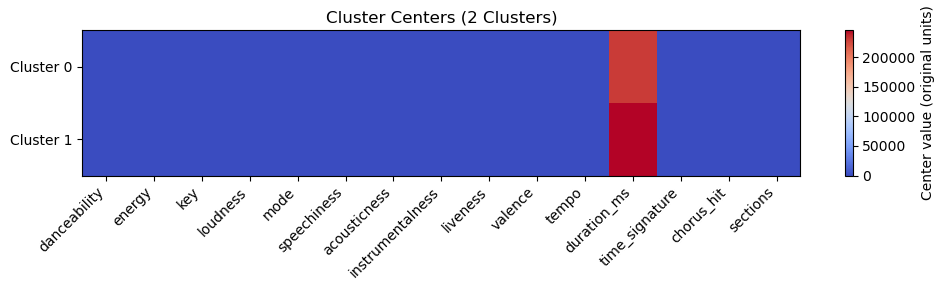

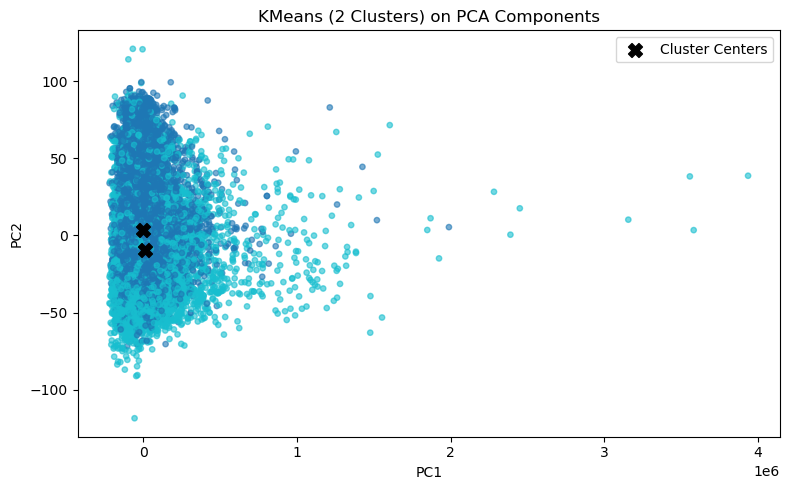


Cluster sizes: {'Cluster 0': 29327, 'Cluster 1': 11779}


In [18]:
# ----------------------------------------
# KMEANS WITH 2 CLUSTERS (HIT vs. FLOP) & FEATURE “IMPORTANCES”
# ----------------------------------------

from sklearn.metrics import silhouette_score

# 1) STANDARDIZE X_all
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

# 2) DEFINE KMEANS PARAM GRID FOR n_clusters=2 (tune init only)
kmeans_param_grid = {
    'n_clusters': [2],  # force exactly two clusters
    'init': ['k-means++', 'random']
}

# 3) TUNE BY SILHOUETTE SCORE (only init varies)
best_init = None
best_silhouette = -1

for init_method in kmeans_param_grid['init']:
    km = KMeans(
        n_clusters=2,
        init=init_method,
        random_state=42
    )
    labels = km.fit_predict(X_scaled)
    
    # silhouette_score requires at least 2 clusters
    sil_score = silhouette_score(X_scaled, labels)
    if sil_score > best_silhouette:
        best_silhouette = sil_score
        best_init = init_method

print("Best KMeans init for 2 clusters (by silhouette):", best_init)
print("Best silhouette score:", best_silhouette)

# 4) FIT KMEANS WITH n_clusters=2 AND BEST INIT
kmeans = KMeans(n_clusters=2, init=best_init, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# 5) EXTRACT CLUSTER CENTERS (inverse‐transform to original feature space)
centers_scaled = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)
cluster_centers_df = pd.DataFrame(
    centers_original,
    index=["Cluster 0", "Cluster 1"],
    columns=features
)

print("\nCluster centers (original feature units) for 2 clusters, init='{}':".format(best_init))
display(cluster_centers_df)

# 6) TOP 5 FEATURES PER CLUSTER
print("\nTop 5 features per cluster (absolute center value) for 2 clusters:\n")
for i in [0, 1]:
    center_vals = cluster_centers_df.loc[f"Cluster {i}"]
    top5 = list(center_vals.abs().nlargest(5).index)
    print(f"Cluster {i}: {top5}")

# 7) HEATMAP OF CLUSTER CENTERS
plt.figure(figsize=(10, 3))
plt.title("Cluster Centers (2 Clusters)")
plt.imshow(cluster_centers_df, aspect="auto", cmap="coolwarm")
plt.colorbar(label="Center value (original units)")
plt.yticks([0, 1], cluster_centers_df.index)
plt.xticks(range(len(features)), features, rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 8) PCA PLOT WITH FINAL CLUSTER LABELS
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_all)

plt.figure(figsize=(8, 5))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=cluster_labels,
    cmap="tab10",
    s=15,
    alpha=0.6
)
centers_pca = pca.transform(centers_original)
plt.scatter(
    centers_pca[:, 0],
    centers_pca[:, 1],
    c='black',
    s=100,
    marker="X",
    label="Cluster Centers"
)
plt.title("KMeans (2 Clusters) on PCA Components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

# 9) CLUSTER SIZES
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_sizes = dict(zip([f"Cluster {u}" for u in unique], counts))
print("\nCluster sizes:", cluster_sizes)


Print Top‐5 Features per Model

# ----------------------------------------
# 10) PRINT TOP‐5 FEATURES FOR EACH MODEL
# ----------------------------------------
top_n = 5
print(f"Top {top_n} features per model:\n")
for model_name in importance_df_all.columns:
    top_feats = list(importance_df_all[model_name].nlargest(top_n).index)
    print(f"{model_name}: {top_feats}")


Save Results to Files

In [20]:
# 0) Ensure output directory exists
output_dir = "./saved_results_2"
os.makedirs(output_dir, exist_ok=True)

# 1) Save hyperparameter‐tuning dictionaries (results, cv_results)
with open(os.path.join(output_dir, "per_decade_and_overall_results.pkl"), "wb") as f:
    pickle.dump({
        "results": results,
        "cv_results": cv_results
    }, f)

# 2) Save best_params_per_decade and best_params_overall
with open(os.path.join(output_dir, "best_params_per_decade.pkl"), "wb") as f:
    pickle.dump(best_params_per_decade, f)

with open(os.path.join(output_dir, "best_params_overall.pkl"), "wb") as f:
    pickle.dump(best_params_overall, f)

# 3) Save best‐params DataFrames (80/20, 70/30, CV5, CV10)
best_params_80_20.to_csv(os.path.join(output_dir, "best_params_80_20.csv"))
best_params_70_30.to_csv(os.path.join(output_dir, "best_params_70_30.csv"))
best_params_cv5.to_csv(os.path.join(output_dir, "best_params_cv5.csv"))
best_params_cv10.to_csv(os.path.join(output_dir, "best_params_cv10.csv"))

# 4) Save feature_importance DataFrame
importance_df_all.to_csv(os.path.join(output_dir, "feature_importances_all_models.csv"))

# # 5) Save KMeans‐related objects
# #    (cluster_centers_df, cluster_labels, cluster_sizes, best_kmeans_params)
# cluster_centers_df.to_csv(os.path.join(output_dir, "kmeans_cluster_centers.csv"))
# with open(os.path.join(output_dir, "kmeans_labels_and_params.pkl"), "wb") as f:
#     pickle.dump({
#         "cluster_labels": cluster_labels,
#         "cluster_sizes": cluster_sizes,
#         "best_kmeans_params": best_kmeans_params
#     }, f)

print(f"All results saved under “{output_dir}/”")

All results saved under “./saved_results/”


Reload Saved Results